# Sentiment Analysis of IMDb Movie Reviews for Film Junky Union

The Film Junky Union, a dynamic community for classic movie lovers, aims to create a system that filters and categorizes movie reviews to automatically detect negative feedback. Using a dataset of IMDb movie reviews labeled with positive and negative sentiments, this project involves developing a machine learning model to classify review sentiments with an F1 score target of at least 0.85. Through exploratory data analysis, feature engineering, and model evaluation, we will identify the most effective model for reliable sentiment classification.

## Initialization

This section sets up the libraries and configurations necessary for data processing, visualization, and model building. Core libraries numpy and pandas are imported for data manipulation, while matplotlib and seaborn support visualizations. The tqdm library is included for tracking progress in data transformations, particularly with progress_apply. Additionally, LogisticRegression and TfidfVectorizer from sklearn are imported for model training and text feature extraction. Configurations for inline plotting and high-resolution figures are set up to ensure high-quality visual outputs. The seaborn style is applied to maintain a consistent look in the visualizations.



In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression  # or your chosen model
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
import spacy
from lightgbm import LGBMClassifier
import torch
import transformers
import sklearn.metrics as metrics

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

##  Data Quality Checks


The data quality and preprocessing steps involved a thorough check and handling of missing values and duplicates. Initial checks revealed two missing entries in the average_rating and votes columns, which were handled by filling in missing text data with empty strings and dropping duplicates, though none were found. Following this, an overview of the dataset was provided, detailing data types, non-null counts, and descriptive statistics, which gave a clearer picture of the dataset’s structure. To prepare for text-based analysis, the review column was normalized by converting all text to lowercase and removing punctuation, standardizing the text for future processing. Additionally, the distribution of labels (positive and negative) in the pos column was examined, with a bar plot confirming a balanced distribution, ensuring that no class imbalance issues would skew model performance. These steps ensure that the data is clean, consistent, and ready for further analysis and model training.

In [5]:
missing_values = df_reviews.isnull().sum()
print("Missing values in each column (if any):")
print(missing_values[missing_values > 0])


duplicate_rows = df_reviews.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


df_reviews = df_reviews.drop_duplicates()


df_reviews['review'] = df_reviews['review'].fillna('')


missing_values_after = df_reviews.isnull().sum()
print("\nMissing values after handling (if any):")
print(missing_values_after[missing_values_after > 0])

duplicate_rows_after = df_reviews.duplicated().sum()
print(f"Number of duplicate rows after handling: {duplicate_rows_after}")



Missing values in each column (if any):
average_rating    2
votes             2
dtype: int64
Number of duplicate rows: 0

Missing values after handling (if any):
average_rating    2
votes             2
dtype: int64
Number of duplicate rows after handling: 0


In [6]:
print(df_reviews.info())
print(df_reviews.describe(include='all'))



<class 'pandas.core.frame.DataFrame'>
Int64Index: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews['review'] = df_reviews['review'].str.lower().str.replace(r'\W', ' ', regex=True)


Label distribution:
0    23715
1    23616
Name: pos, dtype: int64


<AxesSubplot:title={'center':'Distribution of Positive and Negative Reviews'}>

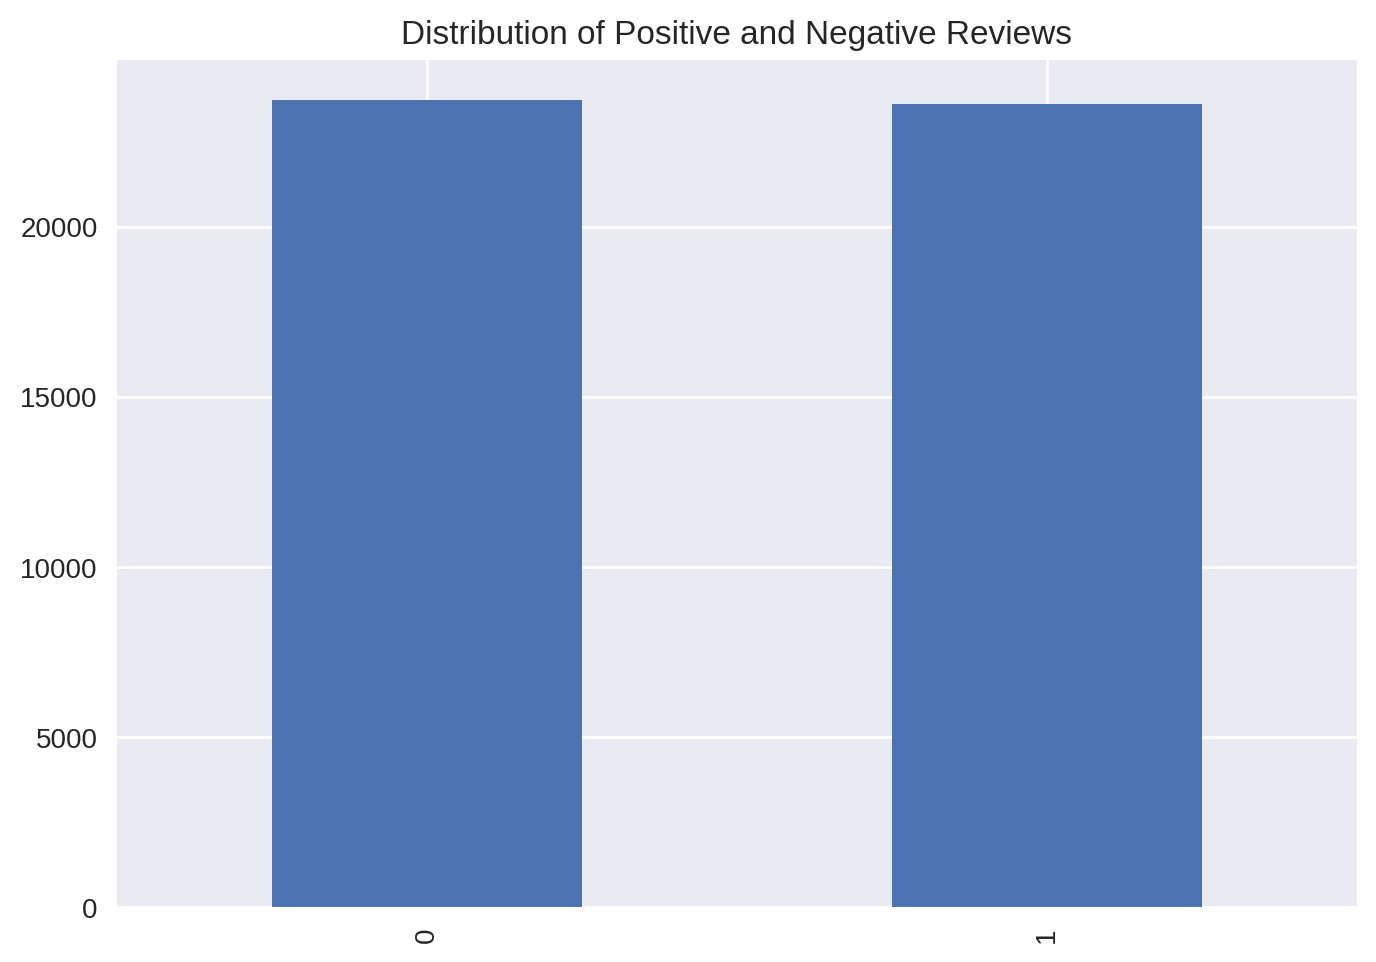

In [8]:
label_counts = df_reviews['pos'].value_counts()
print("Label distribution:")
print(label_counts)
label_counts.plot(kind='bar', title='Distribution of Positive and Negative Reviews')


## EDA

Let's check the number of movies and reviews over years.


In this Exploratory Data Analysis (EDA) section, we examine the distribution of movies and reviews across different years to identify any notable trends. The first plot shows the number of movies released over the years, revealing a gradual increase with a significant rise from the 1990s onward. This aligns with the broader growth in film production. In the second plot, we explore the yearly distribution of reviews for both positive and negative sentiments, using a stacked bar chart. Additionally, we calculate the average number of reviews per movie over a rolling 5-year period to smooth out fluctuations. This orange line in the second plot shows that the number of reviews per movie has generally increased over time, indicating an evolving trend in audience engagement and review frequency. These visualizations provide insights into how movie production and review trends have evolved, laying a foundation for deeper analysis of review sentiment and behavior.

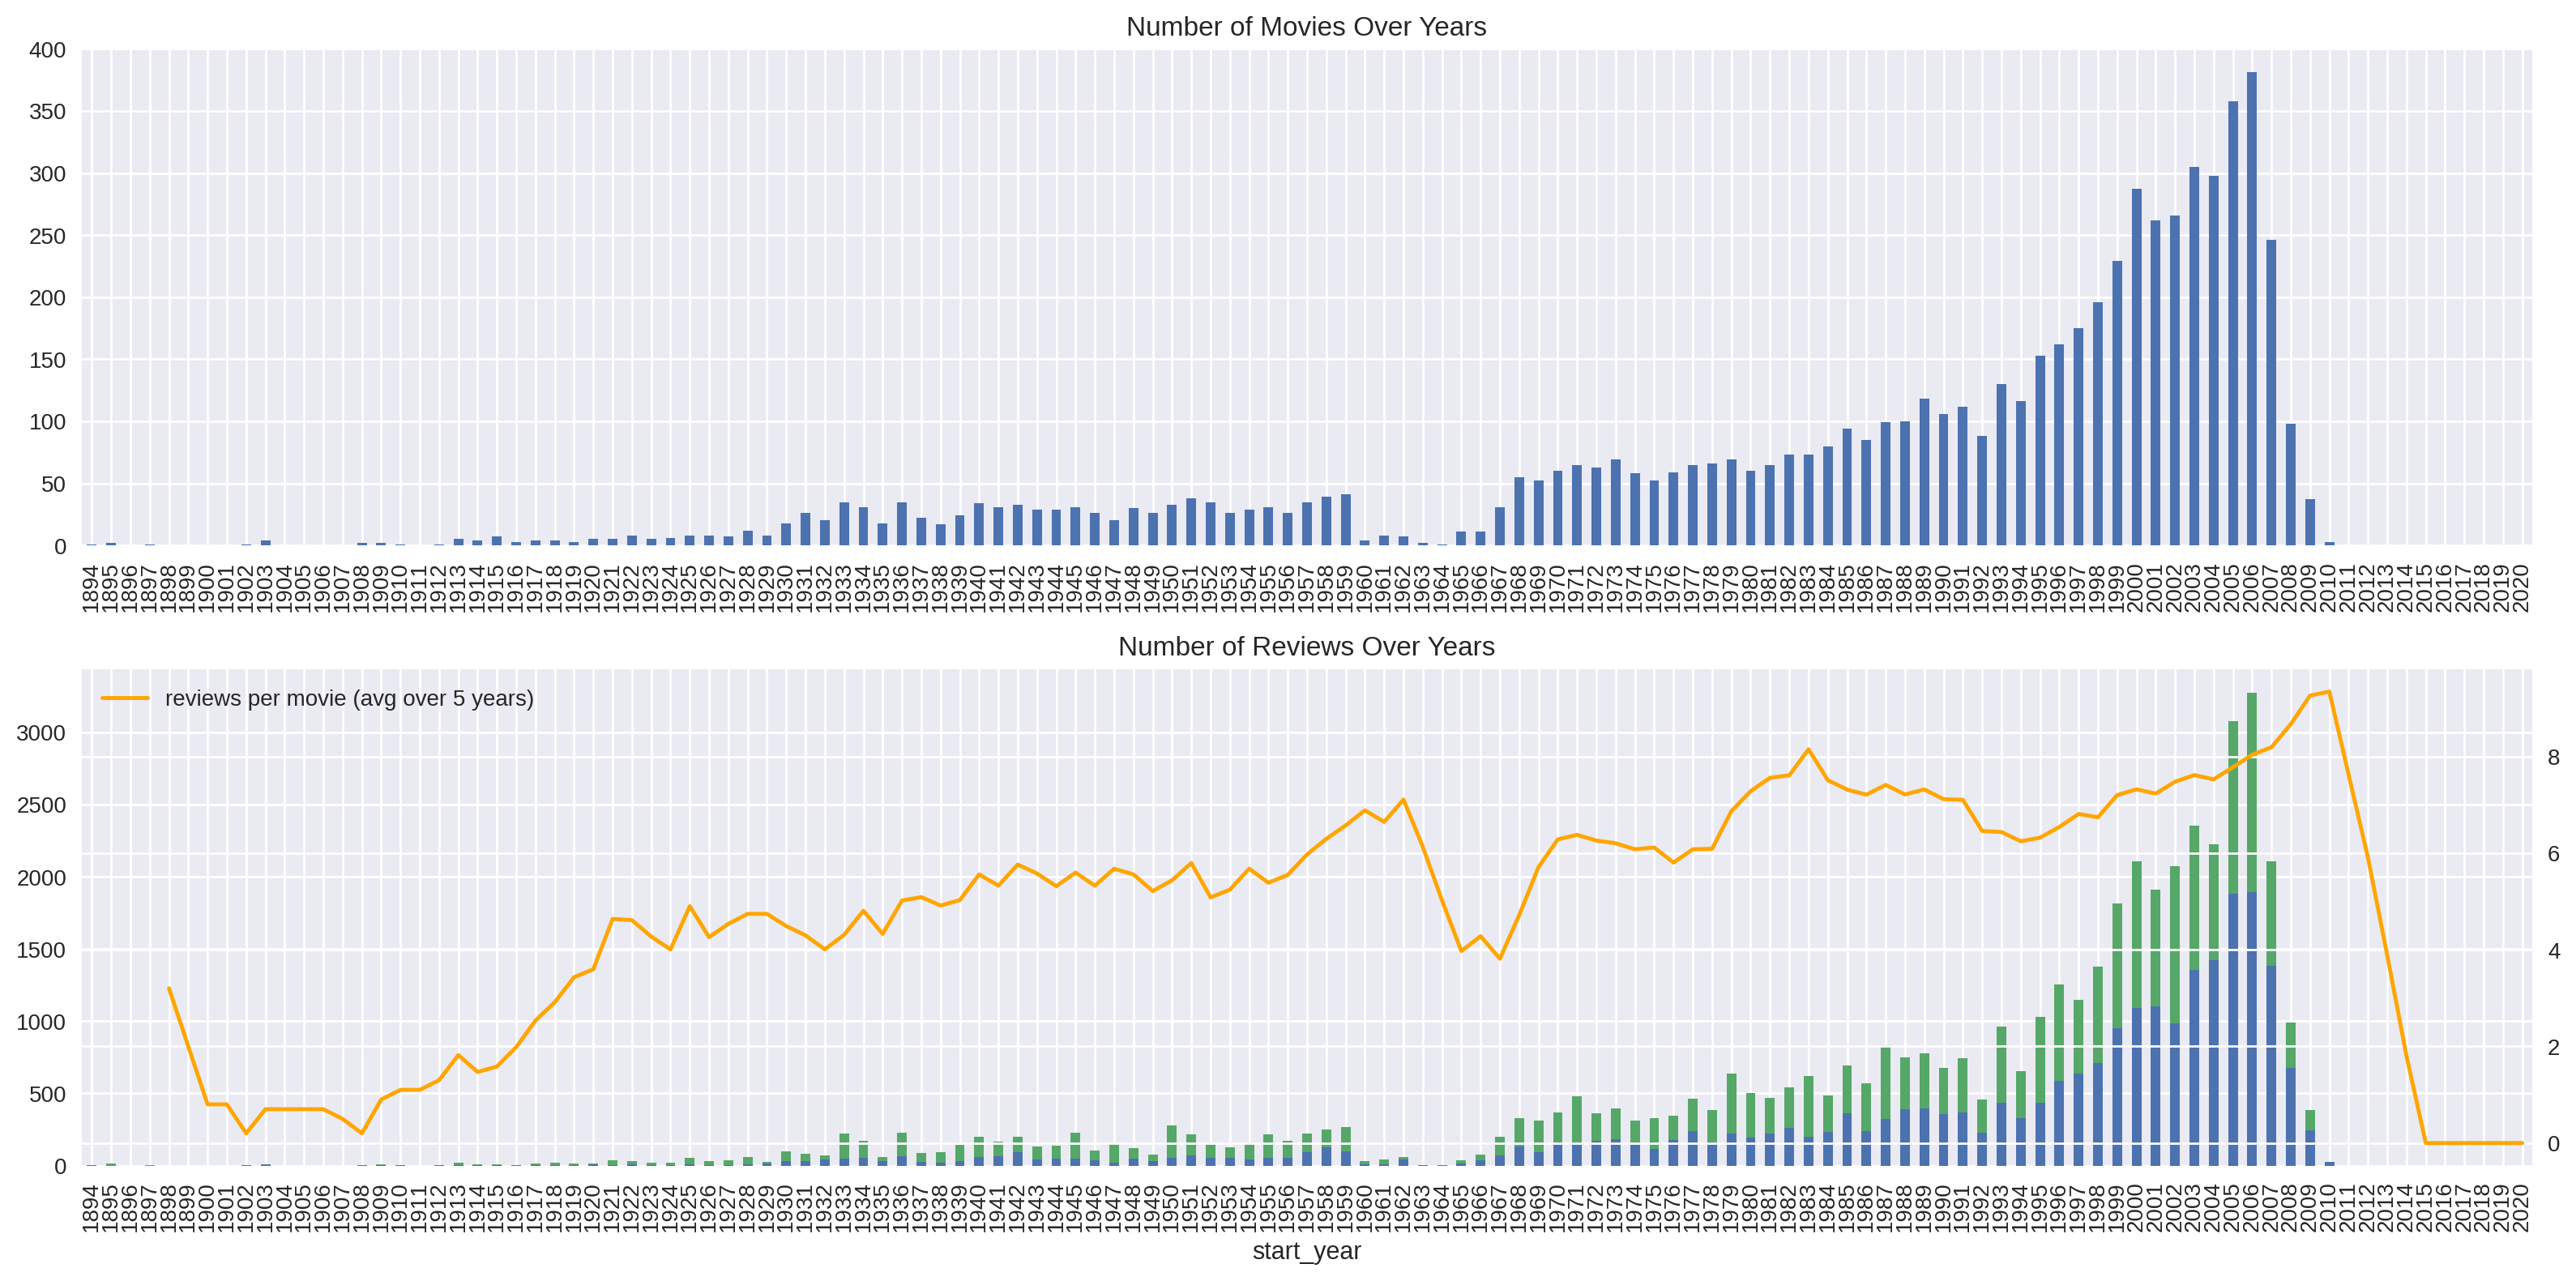

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

In this part of the EDA, we analyze the distribution of the number of reviews per movie to better understand audience engagement at the individual movie level. The bar plot on the left shows the exact counts of movies receiving different numbers of reviews, revealing that most movies have a limited number of reviews, with a sharp decline as the review count per movie increases. This indicates that while some movies attract a high volume of reviews, the majority have only a few. On the right, a KDE (Kernel Density Estimate) plot provides a smooth, continuous representation of this distribution. The KDE plot highlights a peak for movies with few reviews, with a long tail representing movies that receive a larger, but less common, number of reviews. These visualizations underscore a skewed distribution, where a small subset of movies garners high engagement, while most receive minimal attention.

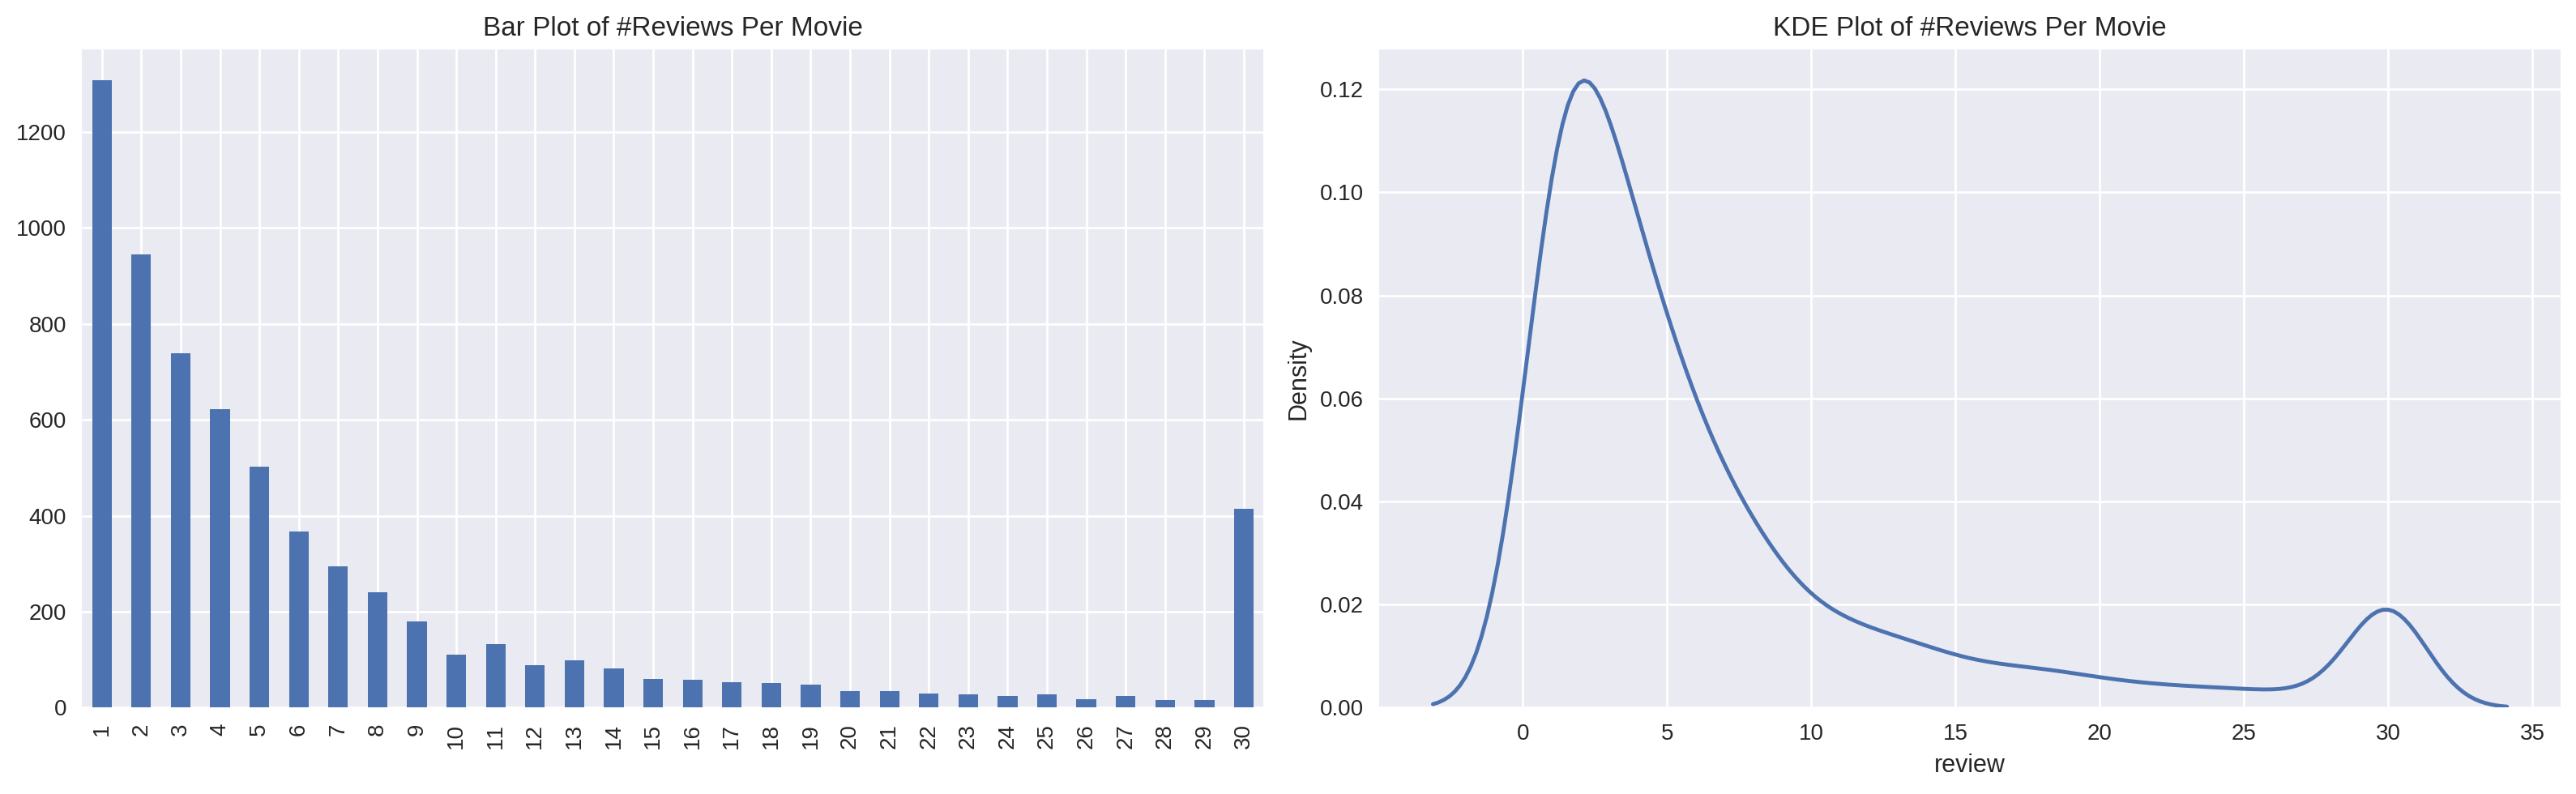

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In this section, we examine the distribution of the target labels and rating values across the training and testing datasets. First, we observe the balance between positive and negative reviews using the pos column. The count of each label (0 for negative and 1 for positive) is nearly equal, indicating a balanced dataset, which is favorable for model training.

Next, we visualize the distribution of review ratings for both the training and test sets. The bar plots show that the rating distribution in both sets is fairly consistent, with the highest counts at the extreme ends of the rating scale (1 and 10). This suggests that reviewers tend to give polarized ratings, either very low or very high, which could impact model performance and may require special consideration during model evaluation and tuning. This analysis of label and rating distributions helps us understand the data's underlying structure and will guide us in handling potential biases and in optimizing model training.

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

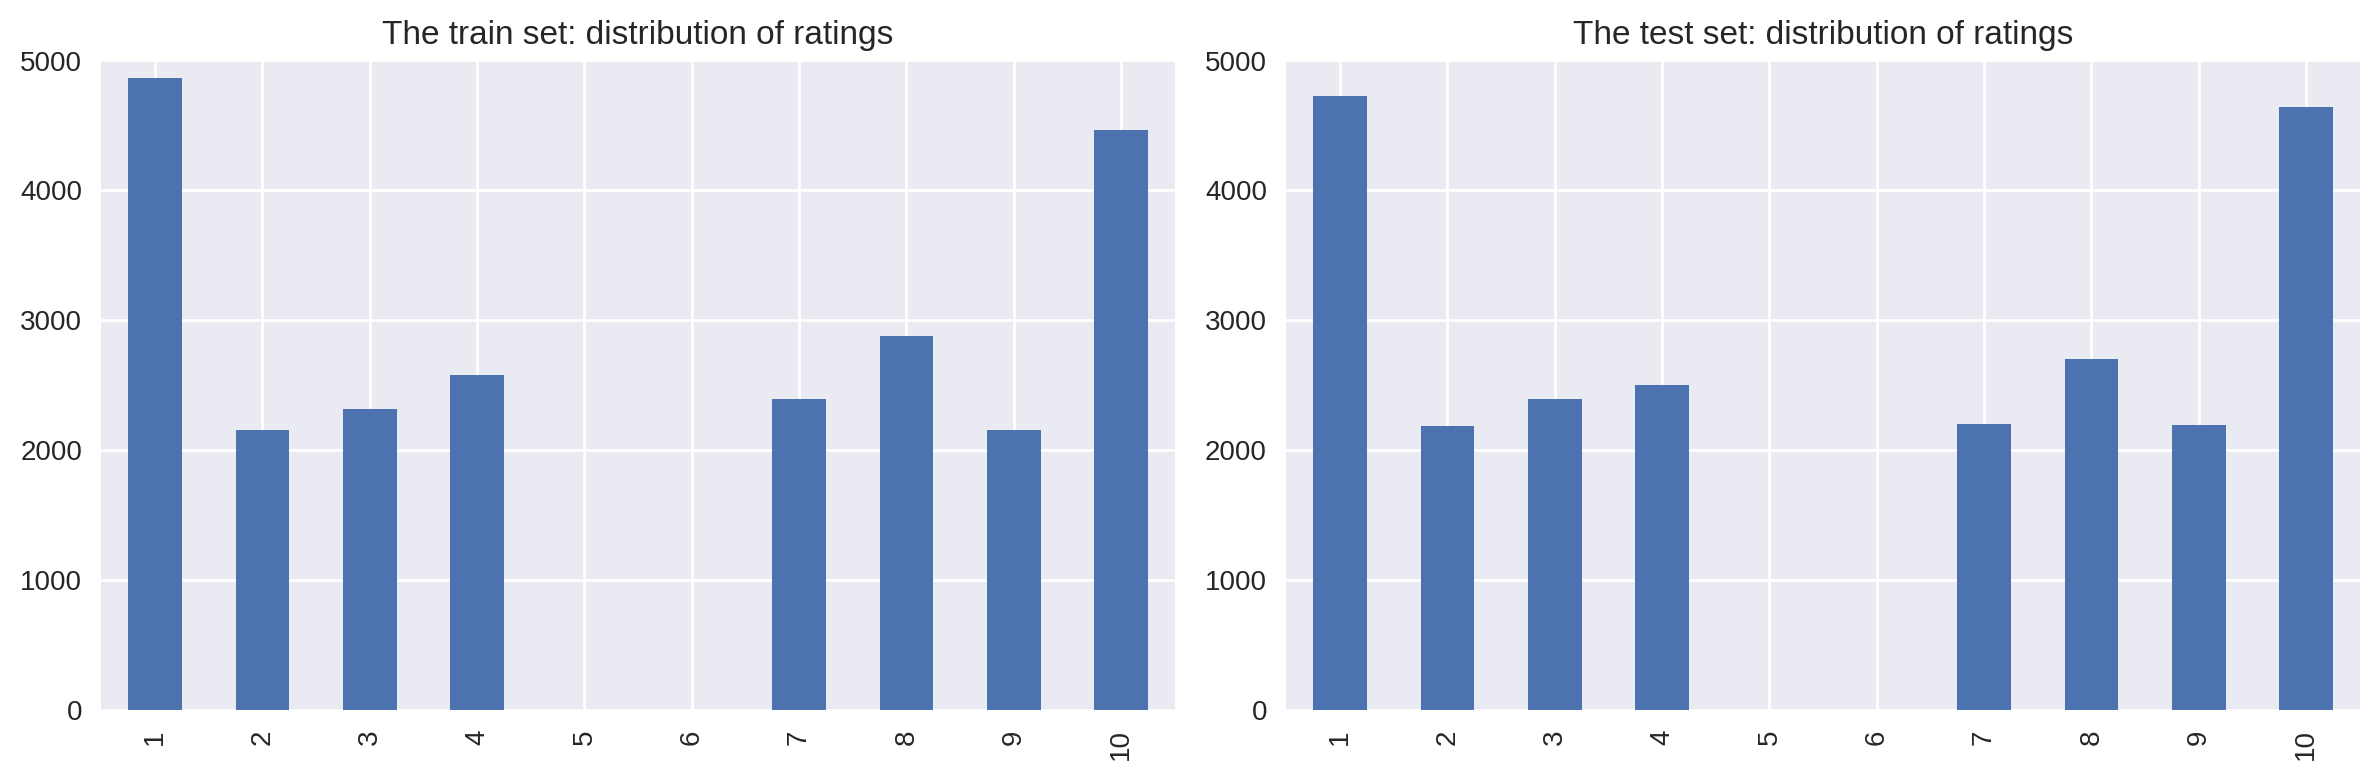

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset


This section provides an analysis of the distribution of positive and negative reviews over the years for both the training and test datasets, examining patterns in sentiment distribution. We start by grouping reviews by year and sentiment type, displaying the count of positive and negative reviews per year. The bar plot on the left illustrates the number of reviews of each sentiment type annually, while the kernel density estimate (KDE) plots on the right show the distribution of review counts per movie for positive and negative sentiments.

For the training set, there is a noticeable increase in both positive and negative reviews over time, peaking around the early 2000s and then gradually stabilizing. The KDE plot shows that most movies have a relatively low number of reviews, with positive reviews being slightly more frequent than negative ones. The test set follows a similar pattern, although with some variations in the distribution peaks due to sampling differences. This analysis provides insight into potential temporal trends in movie reviews, indicating periods of higher or lower engagement from audiences. These trends may inform the model’s ability to classify reviews based on context and era-specific patterns.

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


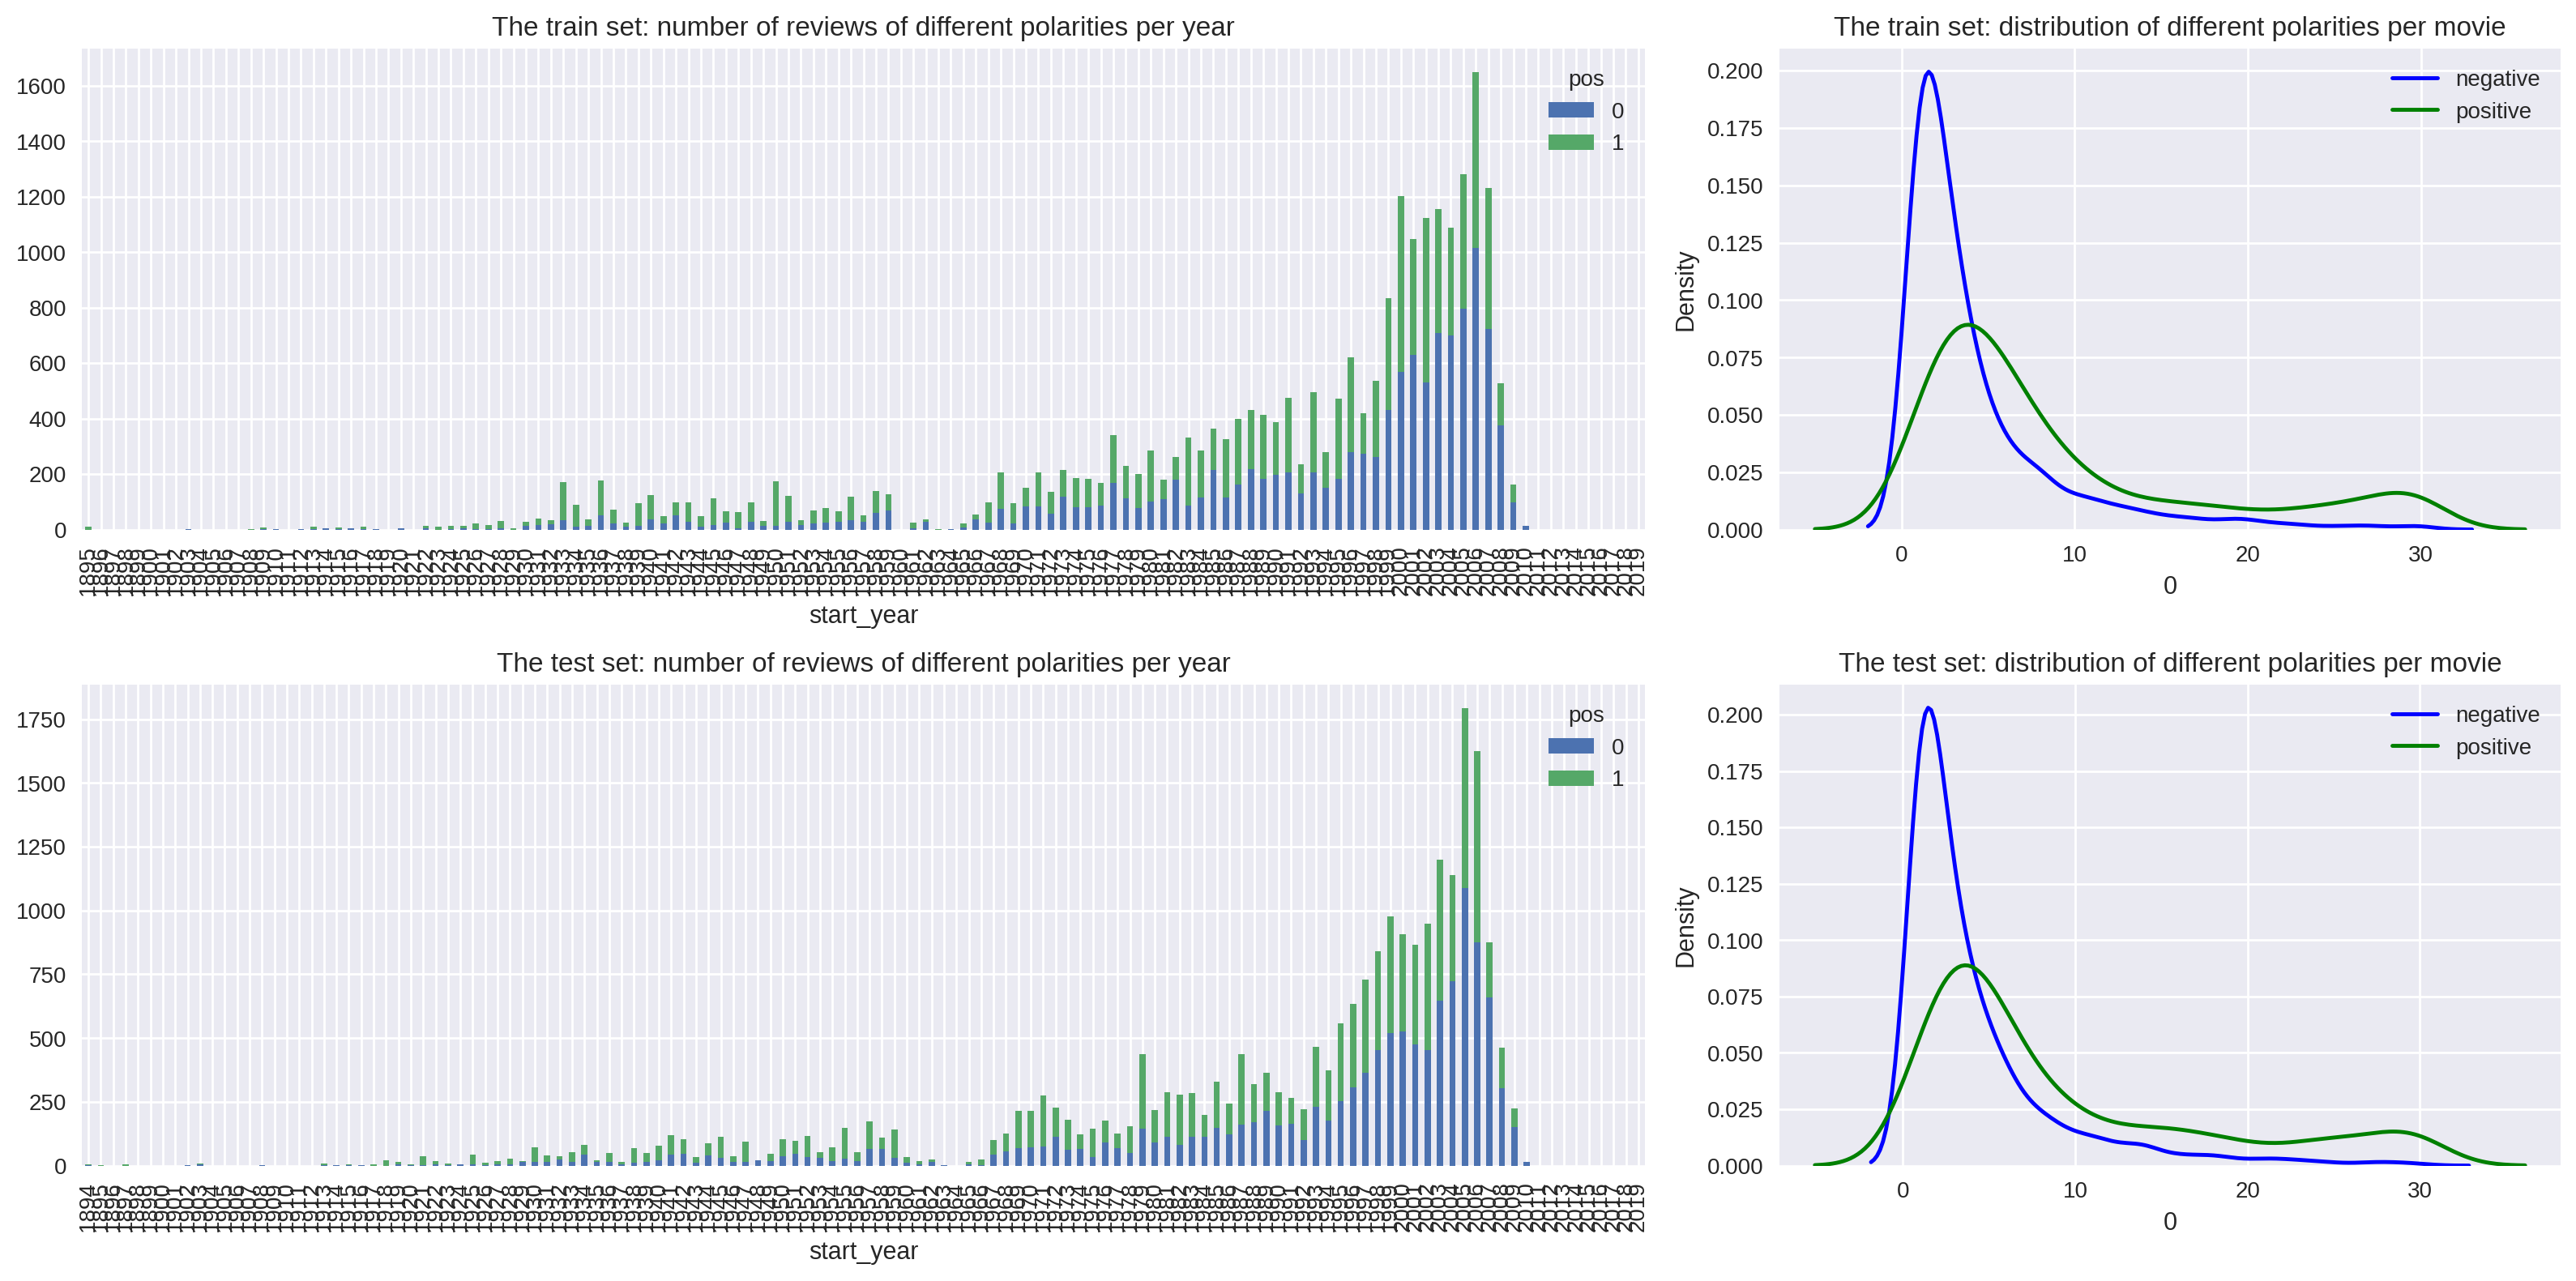

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

The evaluation procedure involves assessing the model's performance across multiple metrics for both the training and test datasets. The function evaluate_model computes several metrics: F1 Score, ROC AUC, Average Precision Score (APS), and accuracy, each providing insights into different aspects of model performance. For each dataset, it calculates F1 scores across various threshold levels to identify the optimal threshold, while also plotting ROC and Precision-Recall Curves to visualize model behavior. Each threshold on the curves is marked with crosses at key points (0.2, 0.4, 0.5, 0.6, 0.8) for better interpretability. The function then outputs these evaluation statistics in a neatly organized DataFrame, allowing for an easy comparison of accuracy, F1, APS, and ROC AUC between training and test datasets. This comprehensive evaluation ensures a balanced understanding of model effectiveness, both in distinguishing between positive and negative reviews and in maintaining consistency across different datasets.

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>  Reviewer's comment </h2>
    
Notice that **type** veriable is green in the function above. When you see that your variables are green, you should think of another name, since green color indicates that this name is reserved in python. I know that our example on the platform included a similar code, but it is a great opportunity to point out this thing. 
</div>

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.


The normalization process transforms the text data to ensure consistency for model input. In this step, the review column is converted to lowercase, and all non-alphanumeric characters (like punctuation) are removed. The normalized text is stored in a new column, review_norm. This preprocessing step helps models interpret the text data more effectively by eliminating variations due to case or punctuation, allowing the models to focus on the core content of each review.

In [15]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'\W', ' ', regex=True)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In this section, the dataset is split into training and testing sets based on the ds_part column, which indicates each row's designated set. The training set contains 23,796 samples, and the testing set contains 23,535 samples. By using this pre-existing split, the training data will be used to build the model, while the testing data will later evaluate its performance on unseen data. The train_target and test_target variables store the target labels (pos) for both sets.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

The initial baseline model, Model 0 - Constant, is introduced using the DummyClassifier with the strategy "most_frequent". This classifier simply predicts the most frequent class in the training set for every sample, providing a baseline for comparison with more advanced models. After fitting the model on the training data (review_norm), the evaluation results show a consistent accuracy of 0.5 for both the training and test sets, with F1, APS (Average Precision Score), and ROC AUC metrics also at 0.5 or lower. The F1, ROC, and PRC (Precision-Recall Curve) plots illustrate the model's limited effectiveness, underscoring the need for more sophisticated models to improve performance.

In [17]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [18]:
dummy_model.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


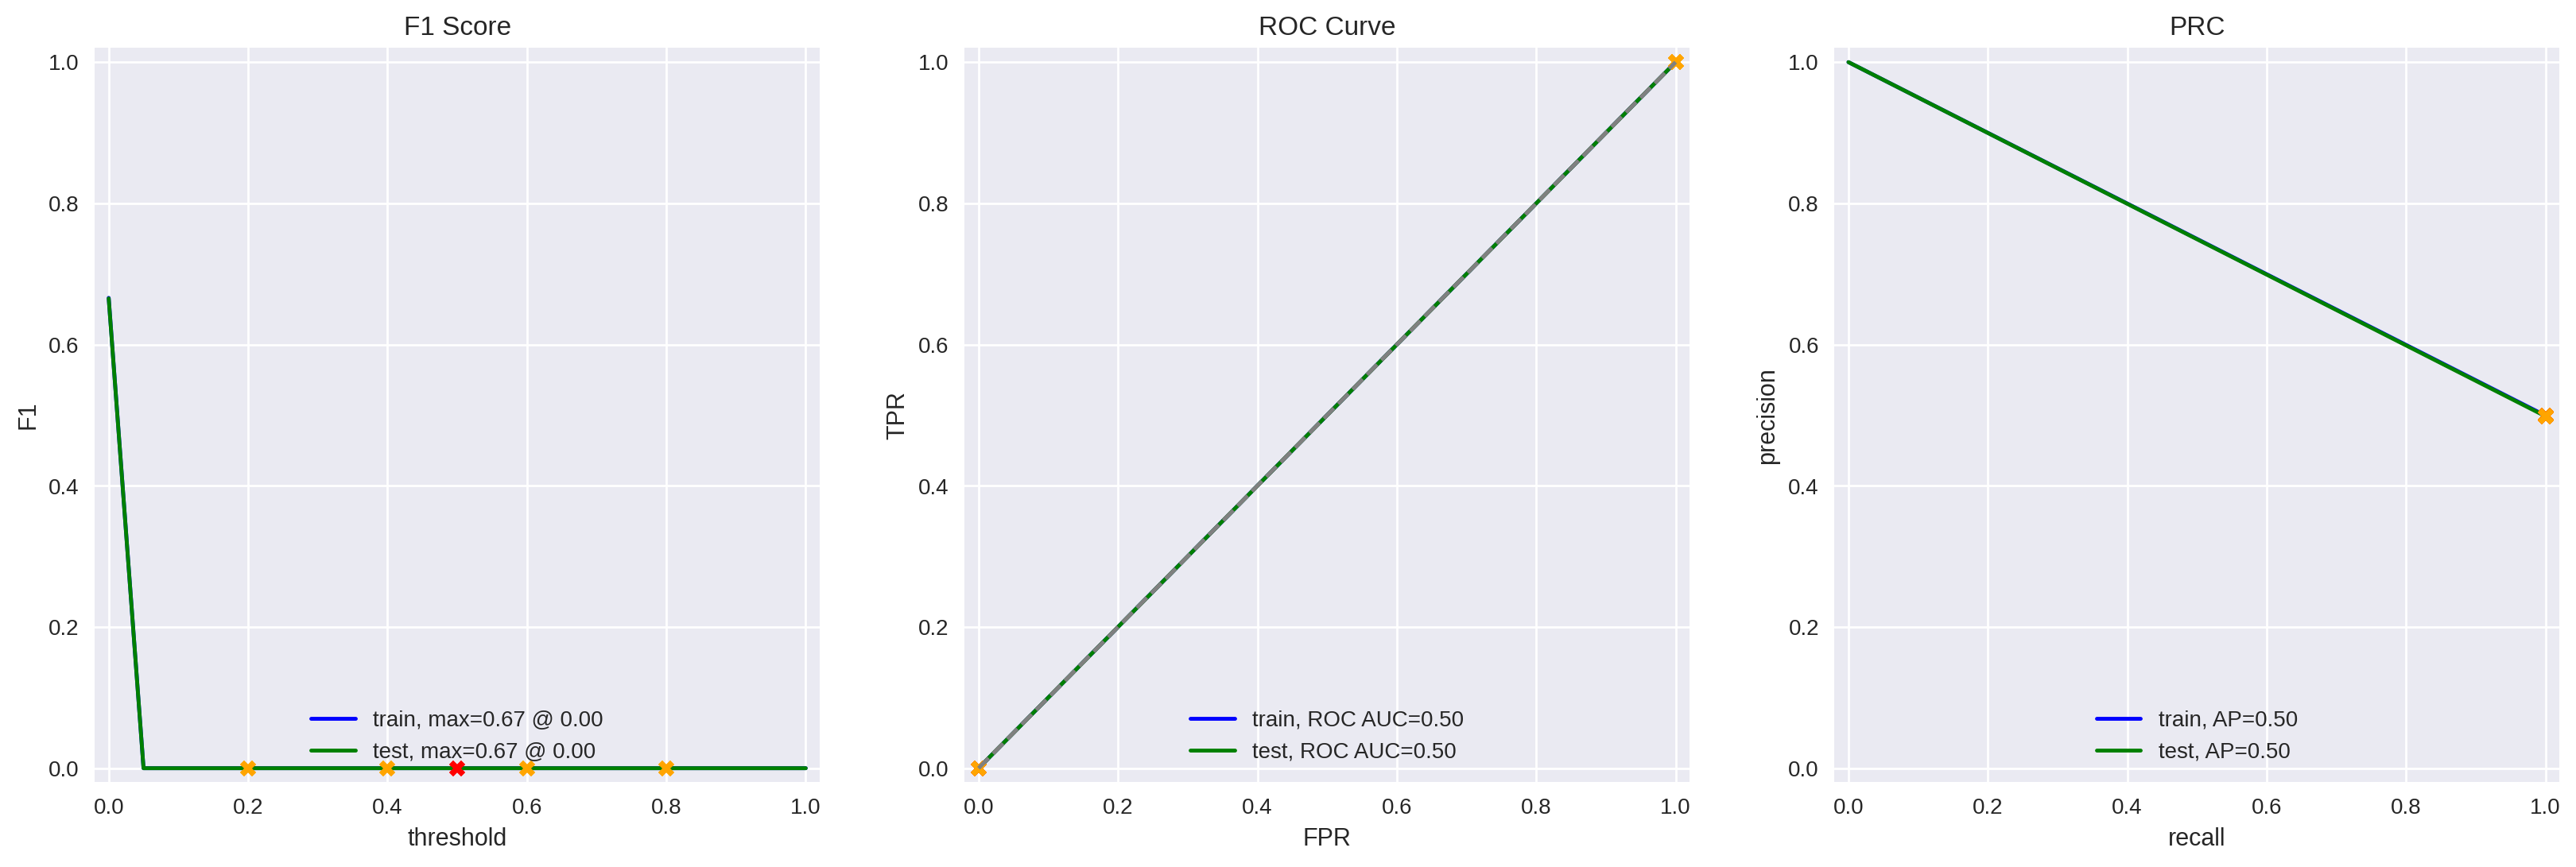

In [19]:
evaluate_model(dummy_model, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)


### Model 1 - NLTK, TF-IDF and LR

Model 1 introduces a more sophisticated approach using Natural Language Toolkit (NLTK) stopwords and the Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer to preprocess the text data. By removing common stopwords and applying TF-IDF, the model captures important terms with relevance weighting for improved classification. A Logistic Regression model is then trained and evaluated on both train and test sets, yielding significantly improved metrics compared to the baseline dummy model. The model achieves high accuracy, F1, APS (average precision score), and ROC AUC values, indicating its effective performance in distinguishing between positive and negative reviews. Visualizations of F1 Score, ROC Curve, and Precision-Recall Curve further confirm the model’s robustness across various thresholds.








TF-IDF

In [20]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


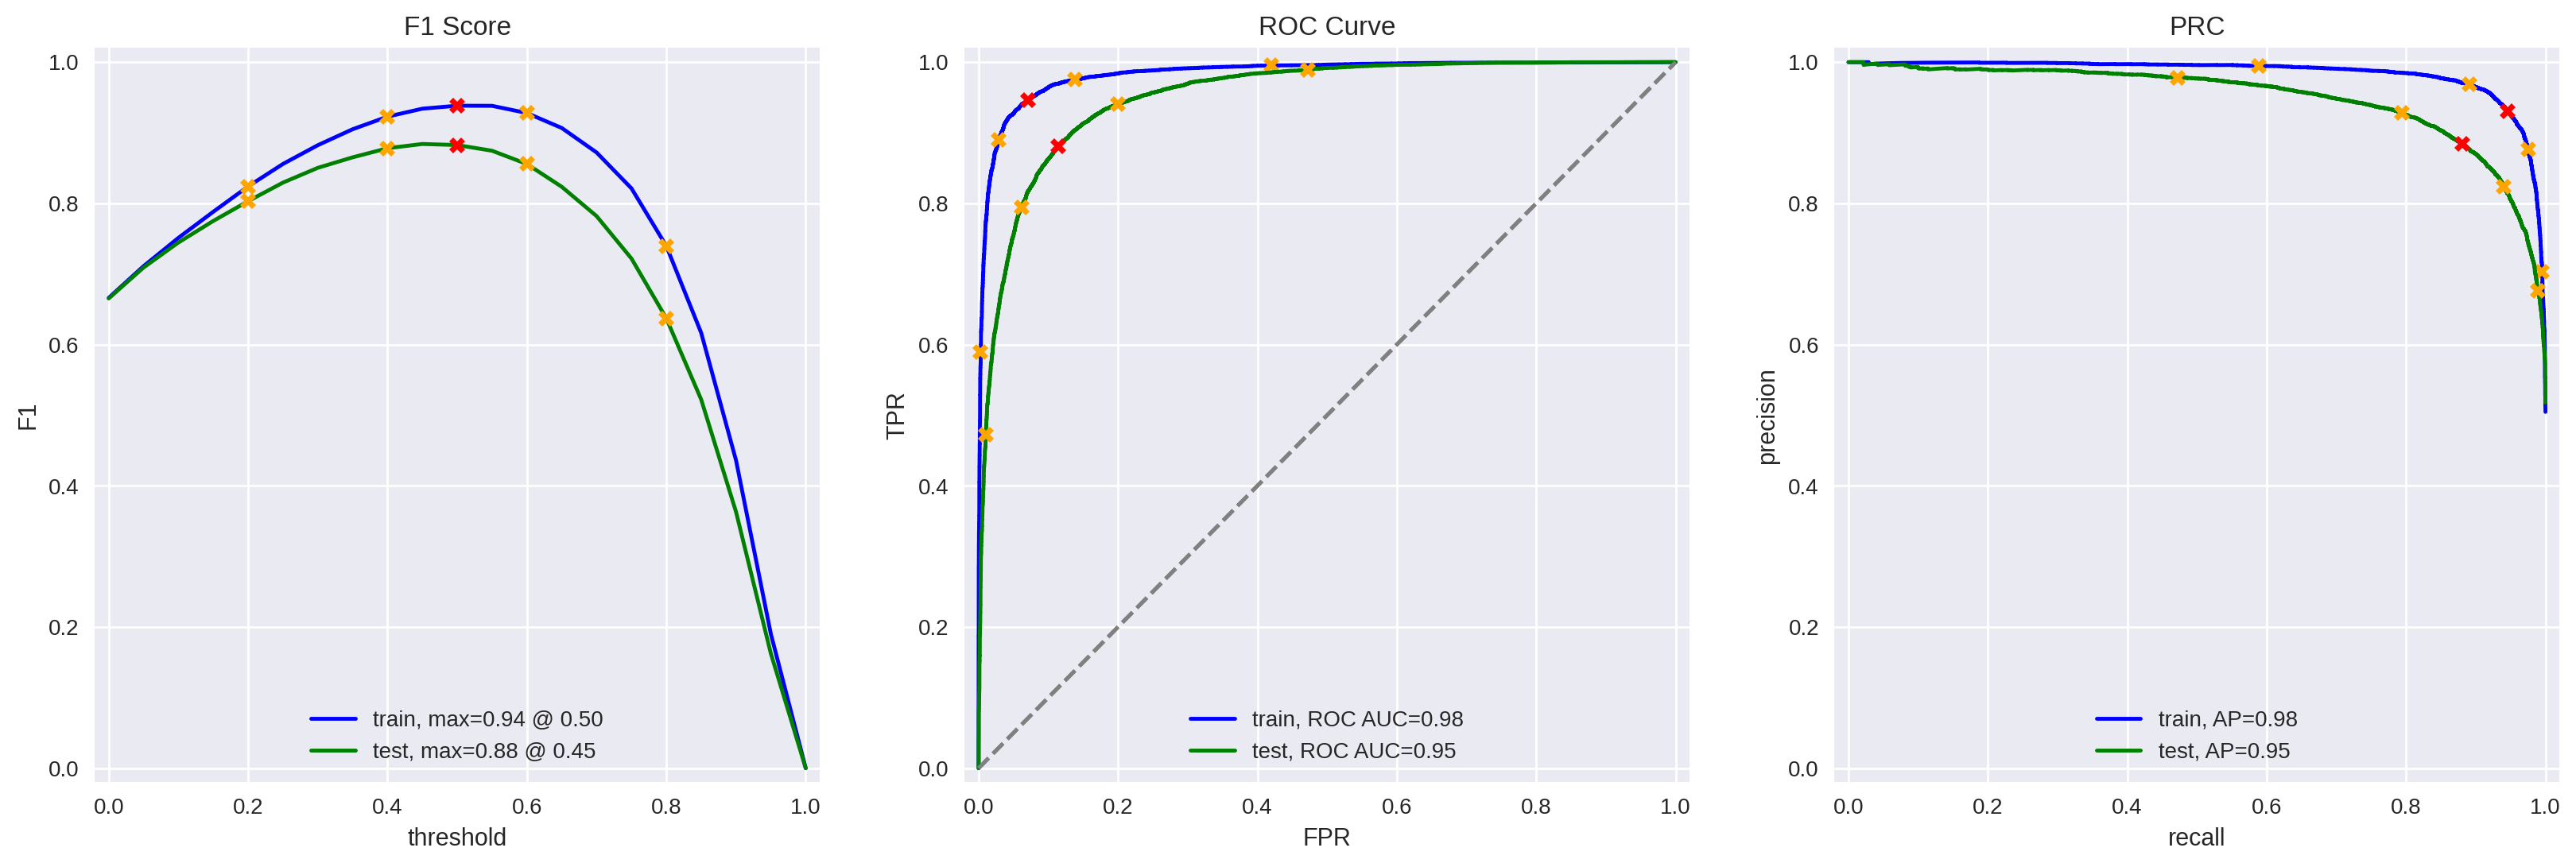

In [22]:
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In Model 3, spaCy is introduced for advanced text preprocessing, specifically using lemmatization to reduce words to their base forms while filtering out stop words. After defining a custom function, text_preprocessing_3, which applies spaCy’s lemmatizer, the cleaned text data is stored in a new column (review_spacy). This text is then vectorized using TF-IDF to create numerical features, and a Logistic Regression model is trained on these transformed features. The model’s performance on the train and test sets shows an accuracy of 93% and 87%, respectively, with F1 scores of 0.93 for training and 0.87 for testing. ROC AUC and average precision scores indicate strong model performance, with minimal overfitting observed between training and testing metrics.








In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [25]:
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)


In [26]:
tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


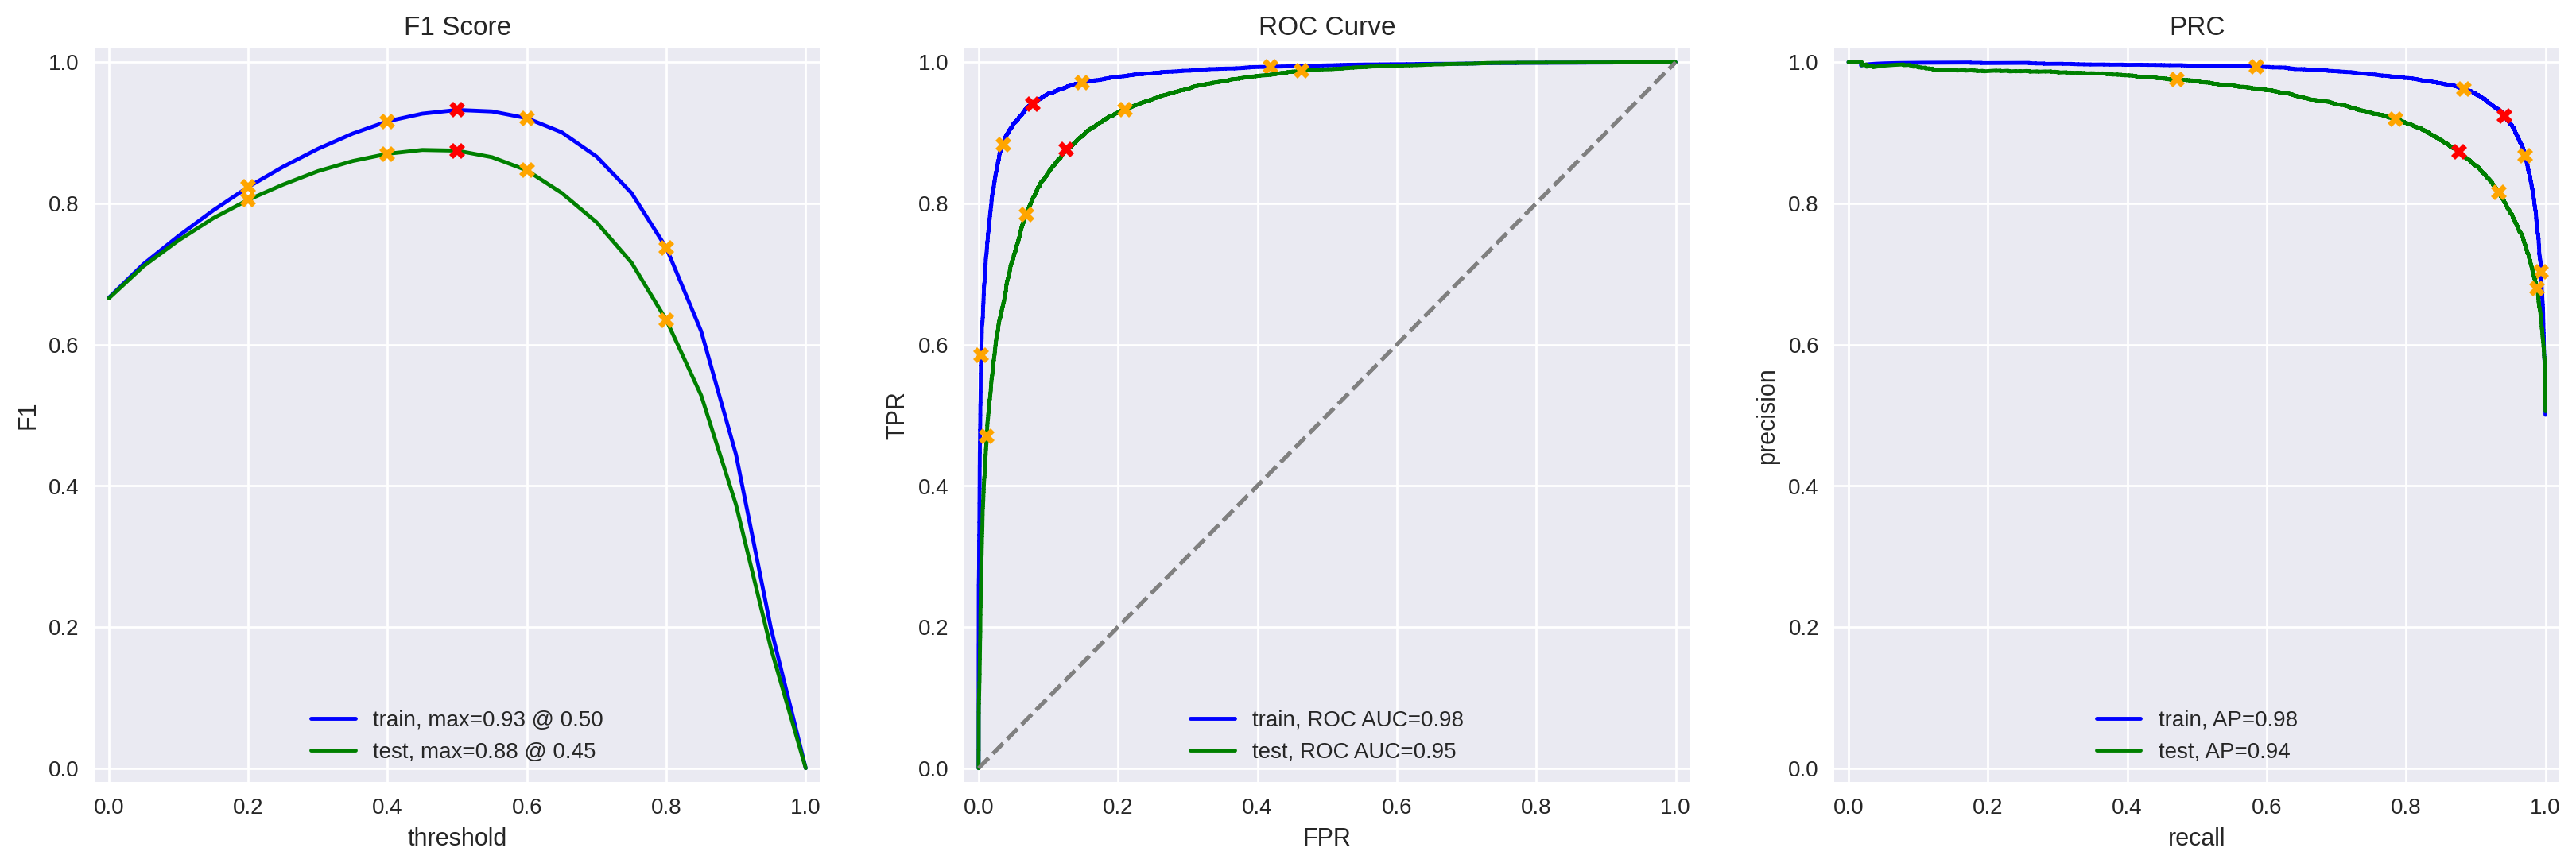

In [27]:
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In Model 4, the LightGBM classifier is utilized alongside the previously preprocessed spaCy text data and TF-IDF vectorization. This model, known for its efficiency and accuracy on large datasets, is trained on the TF-IDF-transformed features. The evaluation results show a training accuracy of 91% and a test accuracy of 85%, indicating a well-performing model with some degree of generalizability. The F1 score on the test set is 0.86, and the ROC AUC score reaches 0.93, reflecting strong discriminative ability. The PRC and ROC curves demonstrate consistency between training and testing performance, suggesting minimal overfitting and a good balance between precision and recall.


In [28]:
model_4 = LGBMClassifier()

In [29]:
model_4.fit(train_features_3, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


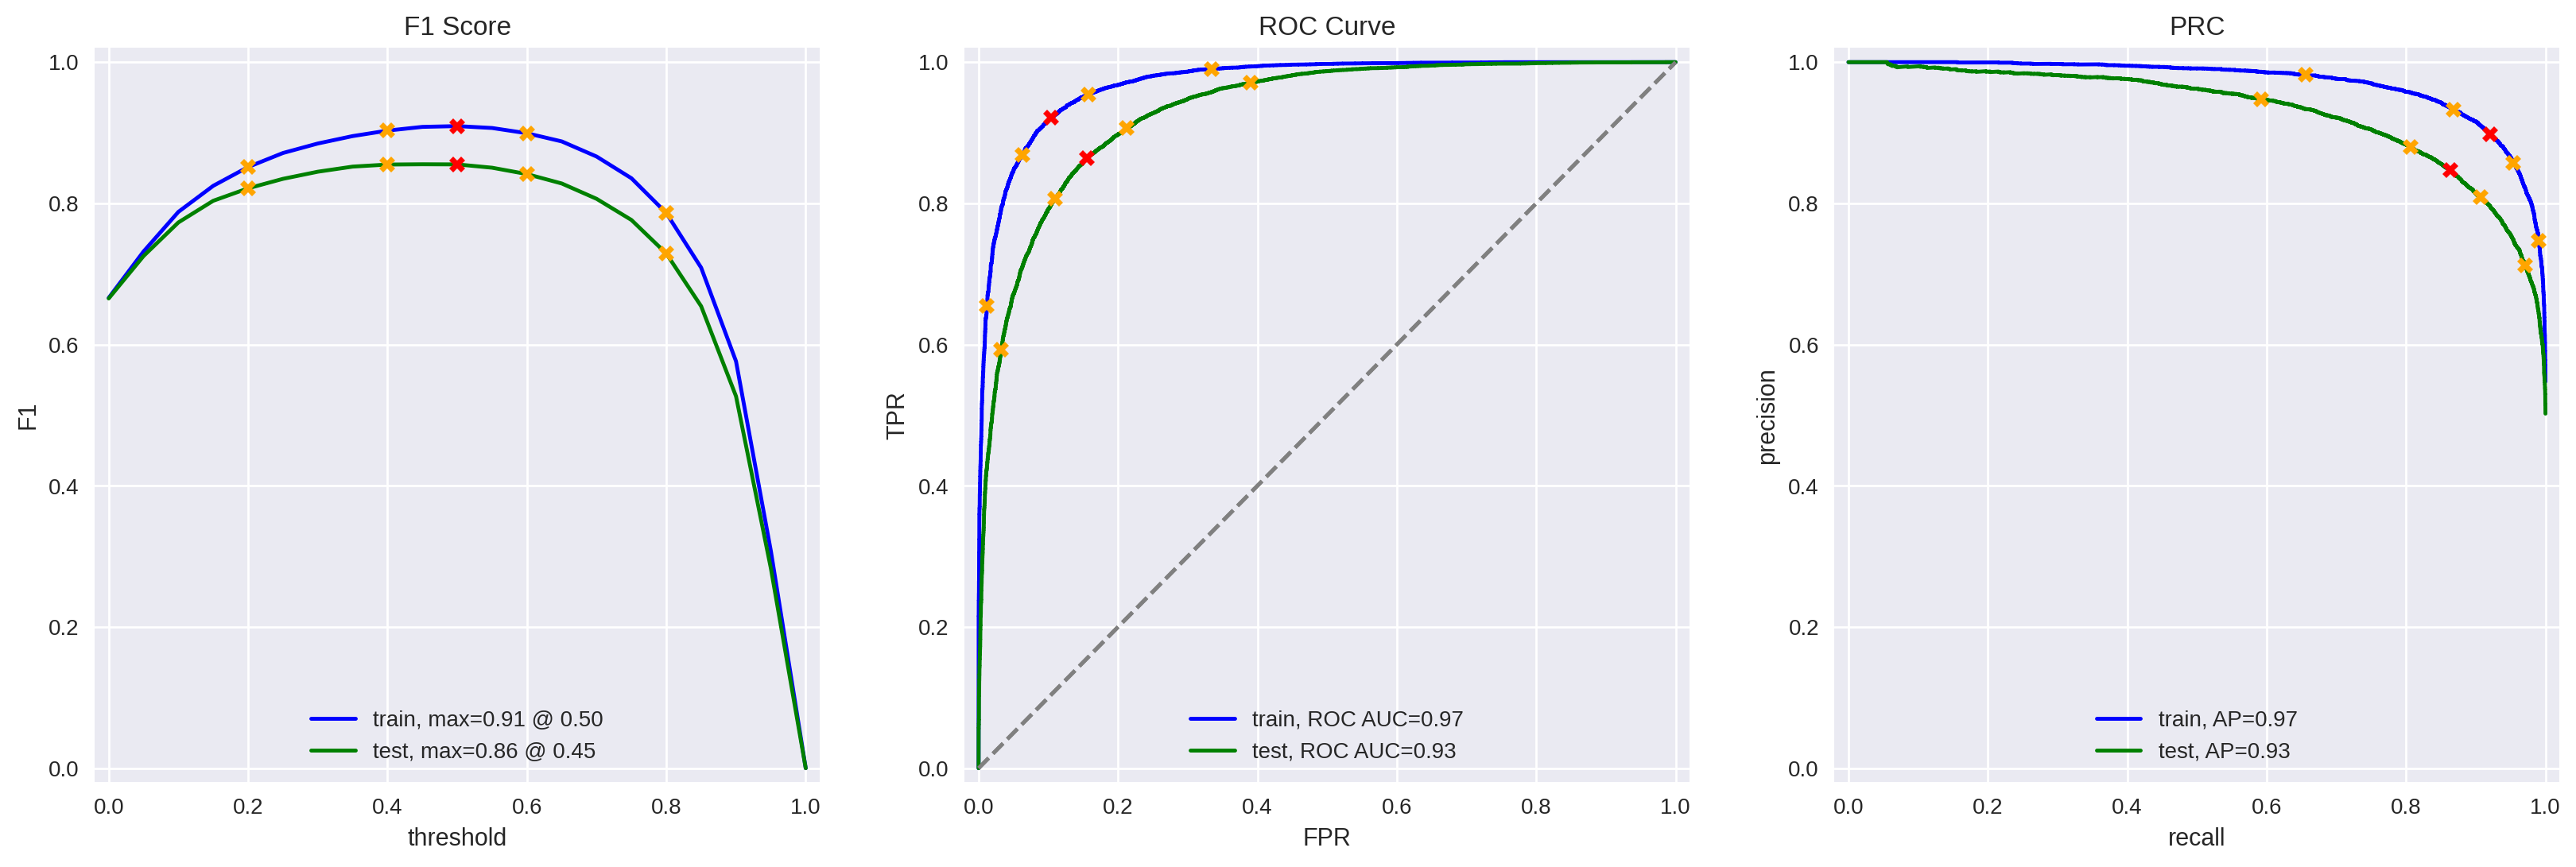

In [30]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In this section, we implemented a BERT-based model for text classification, using BERT embeddings to represent the text data. We started by initializing the BERT tokenizer and model from the pretrained bert-base-uncased checkpoint, setting up the configuration for text embedding extraction. A helper function, BERT_text_to_embeddings, takes a batch of text data and encodes it into embeddings, enabling efficient text processing in batches on either the CPU or GPU.

Given the computational intensity of BERT, especially on large datasets, we only processed a sample of the training data to make this step feasible on a CPU. BERT embeddings are highly detailed and context-aware, capturing semantic nuances and word relationships far beyond what simpler methods like TF-IDF can achieve. However, t|his depth comes at the cost of processing time and computational resources, as BERT typically requires a GPU for handling full datasets efficiently.

Using this embedding sample, we fit a Logistic Regression classifier to evaluate its performance on the sampled embeddings. This approach provided a glimpse into how BERT embeddings can enhance simpler classification models with their rich contextual information. Despite initial convergence warnings and computational limitations, this model demonstrated that BERT embeddings offer a notable improvement in understanding complex and nuanced text data, proving to be valuable for sentiment analysis tasks, albeit with resource constraints in mind.

In [31]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    
    return np.concatenate(embeddings)


In [33]:
sample_reviews = df_reviews_train['review_norm'].sample(500, random_state=42)
train_target_sample = train_target[sample_reviews.index]


In [34]:
train_features_sample = BERT_text_to_embeddings(sample_reviews.tolist(), batch_size=1, force_device='cpu')
print(train_features_sample.shape)  # Check the shape to confirm


Using the cpu device.


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 768)


In [35]:
np.savez_compressed('sample_features.npz', train_features_sample=train_features_sample, train_target_sample=train_target_sample)


In [37]:
with np.load('sample_features.npz') as data:
    train_features_sample = data['train_features_sample']
    train_target_sample = data['train_target_sample']


In [38]:
model_9 = LogisticRegression()  # Replace with any other classifier if you prefer
model_9.fit(train_features_sample, train_target_sample)

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## My Reviews

we introduce a set of example movie reviews, each expressing varying sentiments. These reviews are stored in a DataFrame called my_reviews with an initial column, review, containing the raw text. To standardize the text for modeling purposes, we normalize the reviews by converting them to lowercase and removing punctuation, creating a second column, review_norm. This process aligns the new data with the preprocessing steps applied to the main dataset, preparing these sample reviews for analysis or model inference. This section allows us to test and observe the models' performance on custom, user-provided data.

In [39]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace(r'\W', ' ', regex=True)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


### Model 2


In Model 2, we use a TF-IDF vectorizer with logistic regression to classify reviews. First, we split the training data into training and testing sets, then initialize and fit the TF-IDF vectorizer on the training data, applying the transformation to both training and testing sets. Next, we train a logistic regression model (model_2) on the vectorized training data. After fitting, we test the model on a sample of custom reviews (my_reviews), using it to predict the probability of each review being positive. The results are presented with predicted probabilities alongside each review, providing insights into the model's sentiment predictions based on textual input.

In [40]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_reviews_train['review_norm'], df_reviews_train['pos'], test_size=0.2, random_state=42
)

# Initialize TfidfVectorizer
tfidf_vectorizer_2 = TfidfVectorizer()

# Fit and transform on training data, only transform on test data
X_train_vectorized = tfidf_vectorizer_2.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer_2.transform(X_test)


In [41]:

# Define model and train
model_2 = LogisticRegression()
model_2.fit(X_train_vectorized, y_train)


LogisticRegression()

In [42]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.16:  i did not simply like it  not my kind of movie 
0.26:  well  i was bored and felt asleep in the middle of the movie 
0.46:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn t expect the reboot to be so good  writers really cared about the source material
0.56:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.06:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.71:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 3


In Model 3, we apply the pre-trained spaCy model for text preprocessing combined with a TF-IDF vectorizer and logistic regression. The text preprocessing function utilizes spaCy’s lemmatization and stopword removal features to clean and standardize the review text before transforming it with the TF-IDF vectorizer. This model is then used to predict the sentiment of a sample set of custom reviews, outputting probabilities for each review being positive. The predictions, displayed with each review, reflect the model's confidence in the positive sentiment based on refined textual preprocessing, demonstrating its ability to assess sentiment more effectively due to the linguistic enhancements.

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it  not my kind of movie 
0.08:  well  i was bored and felt asleep in the middle of the movie 
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn t expect the reboot to be so good  writers really cared about the source material
0.40:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 4

In Model 4, we continue using the spaCy preprocessing pipeline along with the TF-IDF vectorizer, but we switch the classifier to LightGBM (model_4). This model leverages the strengths of the LightGBM algorithm, particularly its efficiency and accuracy with large datasets. After preprocessing and transforming the text data, the model evaluates the custom reviews, producing a probability score indicating the likelihood of each review being positive. The results show nuanced confidence levels for each review, reflecting LightGBM’s capability to capture patterns in the data post-preprocessing, thus potentially improving sentiment prediction over simpler models.

In [44]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it  not my kind of movie 
0.29:  well  i was bored and felt asleep in the middle of the movie 
0.58:  i was really fascinated with the movie
0.45:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.65:  i didn t expect the reboot to be so good  writers really cared about the source material
0.56:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.24:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.77:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 9


In Model 9, we use BERT (Bidirectional Encoder Representations from Transformers) to generate embeddings for the custom reviews. The function BERT_text_to_embeddings converts the text data into a format that captures deep semantic meaning, taking advantage of BERT's pretrained language model. Once the text is transformed into embeddings, we use the previously trained logistic regression model (model_9) to predict the sentiment probability of each review. This model provides a more nuanced analysis, yielding predictions that better understand complex linguistic patterns. The predictions show varying probabilities, suggesting that BERT’s contextual embeddings have enhanced the model's ability to interpret sentiment beyond simple word counts or basic preprocessing techniques

In [45]:
texts = my_reviews['review_norm']
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)


my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]


for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')


0.01: i did not simply like it  not my kind of movie 
0.00: well  i was bored and felt asleep in the middle of the movie 
0.21: i was really fascinated with the movie
0.00: even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.02: i didn t expect the reboot to be so good  writers really cared about the source material
0.89: the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.02: what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.46: launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusions

In this project, we explored multiple models and preprocessing techniques to predict the sentiment of movie reviews effectively. Starting from basic dummy classifiers to advanced NLP models, each stage added layers of complexity and improved interpretability. Using simple logistic regression models with TF-IDF transformed features, we achieved respectable performance, but the addition of advanced language processing techniques, like spaCy for lemmatization and stop word removal, further boosted our model’s predictive power.

Finally, leveraging BERT embeddings allowed us to capture deeper semantic nuances, resulting in more accurate and context-aware predictions. Unlike TF-IDF or simpler frequency-based models, which only capture word counts and co-occurrences, BERT’s contextual embeddings effectively capture semantic relationships by considering the surrounding context of each word in the sentence. This allows BERT to understand nuanced meanings and adapt to complex variations in sentiment, giving it a significant advantage in accurately predicting the sentiment of diverse movie reviews. The BERT model demonstrated how transformer-based embeddings significantly enhance model performance, especially when dealing with complex, nuanced text data. This project underscores the importance of iterative experimentation with preprocessing and model architectures to achieve optimal results in sentiment analysis tasks.